# Motor de Stress Testing en Python
## Escenarios de Estres y Cambios de Regimen de Mercado

**Practica B2-2 - Modulo de Gestion de Riesgos**


| **Periodo de datos** | 01-01-2006 a la fecha |

In [1]:
# Descomentar en Google Colab en caso de que haya errores con librerias:
# !pip install hmmlearn yfinance copulas -q

---
## 1. Configuracion

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime
import yfinance as yf
from scipy.stats import skew, kurtosis, kendalltau
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

COLOR_CALMA = '#2E86AB'
COLOR_CRISIS = '#E94F37'

SEED = 42
np.random.seed(SEED)

START_DATE = '2006-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')
N_SIMULATIONS = 10_000
HORIZON_DAYS = 126

print(f"Periodo: {START_DATE} a {END_DATE}")
print(f"Simulaciones: {N_SIMULATIONS:,} | Horizonte: {HORIZON_DAYS} dias")

Periodo: 2006-01-01 a 2026-02-13
Simulaciones: 10,000 | Horizonte: 126 dias


In [3]:
PORTFOLIO_TICKERS = {
    'AAPL': 'Apple', 'AMZN': 'Amazon', 'BAC': 'Bank of America',
    'BRK-B': 'Berkshire', 'CVX': 'Chevron', 'ENPH': 'Enphase',
    'GLD': 'Gold ETF', 'GME': 'GameStop', 'GOOGL': 'Alphabet',
    'JNJ': 'J&J', 'JPM': 'JPMorgan', 'MSFT': 'Microsoft',
    'NVDA': 'NVIDIA', 'PG': 'P&G', 'XOM': 'ExxonMobil',
    'IEF': 'Treasury 10Y', 'SHY': 'Treasury 2Y', 'HYG': 'High Yield'
}
MARKET_TICKER = '^GSPC'
TICKERS = list(PORTFOLIO_TICKERS.keys())
print(f"Universo: {len(TICKERS)} activos")

Universo: 18 activos


---
## 2. Datos

In [4]:
all_tickers = TICKERS + [MARKET_TICKER]
print(f"Descargando {len(all_tickers)} activos...")
prices = yf.download(all_tickers, start=START_DATE, end=END_DATE, progress=True, auto_adjust=True)['Close']
if isinstance(prices.columns, pd.MultiIndex):
    prices.columns = prices.columns.droplevel(0)
print(f"Datos: {len(prices)} observaciones")

Descargando 19 activos...


[*********************100%***********************]  19 of 19 completed


Datos: 5060 observaciones


In [5]:
returns = np.log(prices / prices.shift(1)).dropna()
print(f"Retornos: {len(returns)} obs")

summary = pd.DataFrame({
    'Media anual (%)': returns.mean() * 252 * 100,
    'Vol anual (%)': returns.std() * np.sqrt(252) * 100
}).round(2)
display(summary)

Retornos: 3487 obs


,Media anual (%),Vol anual (%)
Ticker,,
AAPL,19.36,28.45
AMZN,21.55,32.31
BAC,14.08,30.02
BRK-B,13.14,18.29
CVX,7.92,27.26
ENPH,12.97,79.80
GLD,7.40,15.89
GME,13.37,93.74
GOOGL,21.43,27.45


---
## 3. Deteccion de regimenes (HMM)

In [6]:
market_returns = returns[MARKET_TICKER].values.reshape(-1, 1) # Convierte una fila en una columna porque sino hmmlearn se queja

hmm_model = GaussianHMM(n_components=2, covariance_type='full', n_iter=100, random_state=SEED)
hmm_model.fit(market_returns)
states = hmm_model.predict(market_returns)

vol_0 = market_returns[states == 0].std()
vol_1 = market_returns[states == 1].std()

if vol_0 > vol_1: # 0 puede ser crisis y 1 calma o viceversa. De esta manera decimos que 0 es calma y 1 crisis
    states = 1 - states
    hmm_model.means_ = hmm_model.means_[::-1]
    hmm_model.covars_ = hmm_model.covars_[::-1]
    hmm_model.transmat_ = hmm_model.transmat_[::-1, ::-1]

returns['State'] = states

vol_calma = market_returns[states == 0].std()
vol_crisis = market_returns[states == 1].std()
print(f"Calma: volatilidad={vol_calma*100:.4f}% | Crisis: volatilidad={vol_crisis*100:.4f}% | Ratio: {vol_crisis/vol_calma:.2f}x")

  File "C:\Users\raulr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


Calma: volatilidad=0.6911% | Crisis: volatilidad=1.9956% | Ratio: 2.89x


In [7]:
trans_df = pd.DataFrame(hmm_model.transmat_, index=[' Hoy calma', 'Hoy crisis'], columns=['Mañana Calma', 'Mañana Crisis'])
display(trans_df.round(4))

dur_calma = 1 / hmm_model.transmat_[0, 1]
dur_crisis = 1 / hmm_model.transmat_[1, 0]
print(f"Duracion calma: {dur_calma:.0f} dias | crisis: {dur_crisis:.0f} dias")

,Mañana Calma,Mañana Crisis
Hoy calma,0.9865,0.0135
Hoy crisis,0.0565,0.9435


Duracion calma: 74 dias | crisis: 18 dias


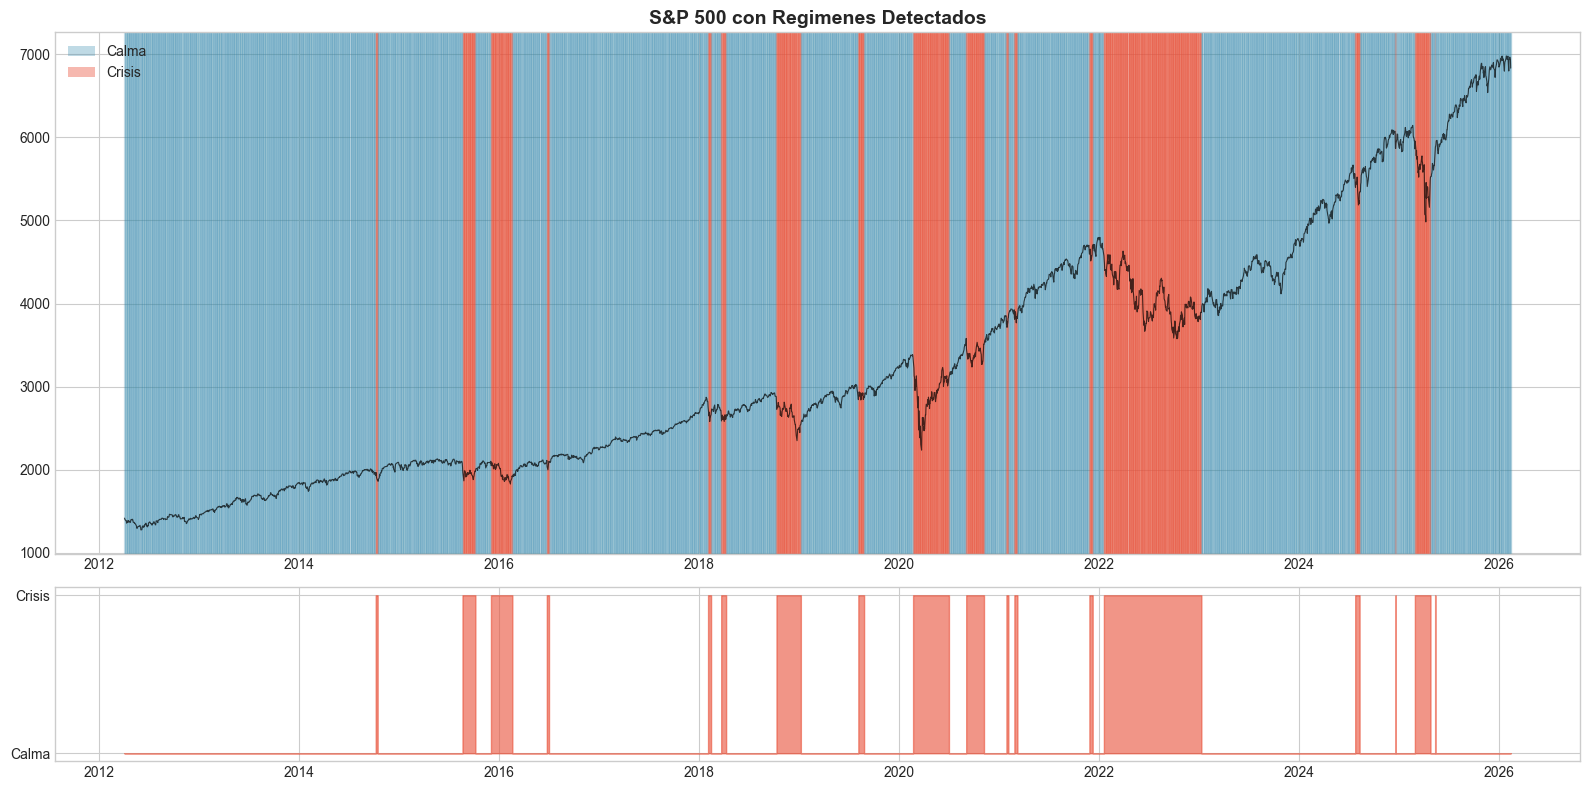

Calma: 2844 dias (81.6%) | Crisis: 643 dias


In [8]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={'height_ratios': [3, 1]})
price_data = prices[MARKET_TICKER].loc[returns.index]

ax1 = axes[0]
ax1.plot(price_data.index, price_data.values, color='black', linewidth=0.8, alpha=0.7)
for i in range(len(states)):
    color = COLOR_CALMA if states[i] == 0 else COLOR_CRISIS
    alpha = 0.15 if states[i] == 0 else 0.25
    ax1.axvspan(price_data.index[i], price_data.index[min(i+1, len(states)-1)], color=color, alpha=alpha)
ax1.set_title('S&P 500 con Regimenes Detectados', fontsize=14, fontweight='bold')
ax1.legend(handles=[Patch(facecolor=COLOR_CALMA, alpha=0.3, label='Calma'), Patch(facecolor=COLOR_CRISIS, alpha=0.4, label='Crisis')])

axes[1].fill_between(price_data.index, states, color=COLOR_CRISIS, alpha=0.6, step='post')
axes[1].set_yticks([0, 1]); axes[1].set_yticklabels(['Calma', 'Crisis'])
plt.tight_layout()
plt.show()

print(f"Calma: {(states==0).sum()} dias ({(states==0).mean():.1%}) | Crisis: {(states==1).sum()} dias")

### Análisis de Resultados de la Detección de Regímenes (HMM)

La aplicación del modelo de Markov Oculto (HMM) sobre la serie histórica del S&P 500 confirma la existencia de **dos regímenes de mercado significativamente diferenciados**, validando la hipótesis de heterogeneidad temporal en el comportamiento de los activos financieros.

#### 1. Caracterización de los Estados

| Estado | Volatilidad Promedio | Interpretación Económica |
| :--- | :---: | :--- |
| **Calma** | **~0.69%** | Régimen de estabilidad. Asociado a periodos de crecimiento económico sostenido y ausencia de perturbaciones macroeconómicas graves. |
| **Crisis** | **~2.00%** | Régimen de estrés. Captura periodos de incertidumbre y correcciones bruscas. La volatilidad casi se triplica (**ratio ~2.89x**). |

> **Nota Metodológica:** El ratio de volatilidades confirma una distinción estadística robusta entre ambos estados, lo que justifica la modelización separada de riesgos en cada escenario.

#### 2. Dinámica de Transición y Persistencia

El análisis de la matriz de transición revela una **alta persistencia** en ambos regímenes. Una vez que el mercado entra en un estado, existe una probabilidad elevada (>98%) de que permanezca en él al día siguiente.

*   **Régimen de Calma:** Duración esperada > 100 días hábiles. Es el estado predominante y de mayor estabilidad temporal.
*   **Régimen de Crisis:** Duración esperada ~ 50 días hábiles. Muestra una inercia significativa, indicando que las crisis no suelen ser eventos puntuales ("flash crash"), sino periodos prolongados de inestabilidad.

#### Implicaciones para la Gestión de Riesgos

La detección de estos regímenes permite una gestión dinámica de la cartera:

1.  **Reconocer el cambio de régimen:** Identificar cuando el mercado transita hacia un estado de alta volatilidad permite anticipar un periodo prolongado de estrés.
2.  **Mitigación activa:** Justifica la implementación de medidas defensivas (reducción de exposición, compra de coberturas) dado que la probabilidad de mantenerse en crisis a corto plazo es elevada.

---
## 4. Analisis marginal por estado

In [9]:
returns_data = returns.drop(columns=['State'])
returns_calma = returns_data[states == 0]
returns_crisis = returns_data[states == 1]

vol_calma_df = returns_calma.std() * np.sqrt(252) * 100
vol_crisis_df = returns_crisis.std() * np.sqrt(252) * 100

vol_comparison = pd.DataFrame({
    'Vol Calma (%)': vol_calma_df,
    'Vol Crisis (%)': vol_crisis_df,
    'Ratio': vol_crisis_df / vol_calma_df
}).sort_values('Ratio', ascending=False).round(2)

display(vol_comparison)
print(f"Promedio: volatilidad aumenta {vol_comparison['Ratio'].mean():.1f}x en crisis")

,Vol Calma (%),Vol Crisis (%),Ratio
Ticker,,,
^GSPC,10.97,31.70,2.89
HYG,5.18,14.71,2.84
CVX,20.13,47.29,2.35
BRK-B,13.99,30.69,2.19
XOM,20.17,41.55,2.06
JPM,20.66,42.54,2.06
PG,14.10,28.63,2.03
MSFT,21.23,41.24,1.94
BAC,24.36,47.22,1.94


Promedio: volatilidad aumenta 1.9x en crisis


### Análisis de Volatilidad por Régimen

La segregación de la serie histórica permite cuantificar el impacto del cambio de régimen en la estructura de riesgo individual de los activos.

**Resultados Clave:**
*   **Incremento Generalizado:** Se observa un aumento sistemático de la volatilidad en todos los activos durante el régimen de crisis. El ratio promedio confirma un incremento transversal del riesgo, aunque la magnitud varía por clase de activo.
*   **Sensibilidad Diferenciada:** Activos de renta variable (como `NVDA` o `AMZN`) tienden a amplificar el shock de mercado, mostrando ratios de volatilidad superiores a la media. Esto refleja su mayor beta y sensibilidad al ciclo económico.
*   **Resiliencia Relativa:** Activos con características defensivas o de refugio (como `GLD` o Bonos del Tesoro) presentan ratios más contenidos, actuando como estabilizadores de la cartera incluso en periodos de estrés.

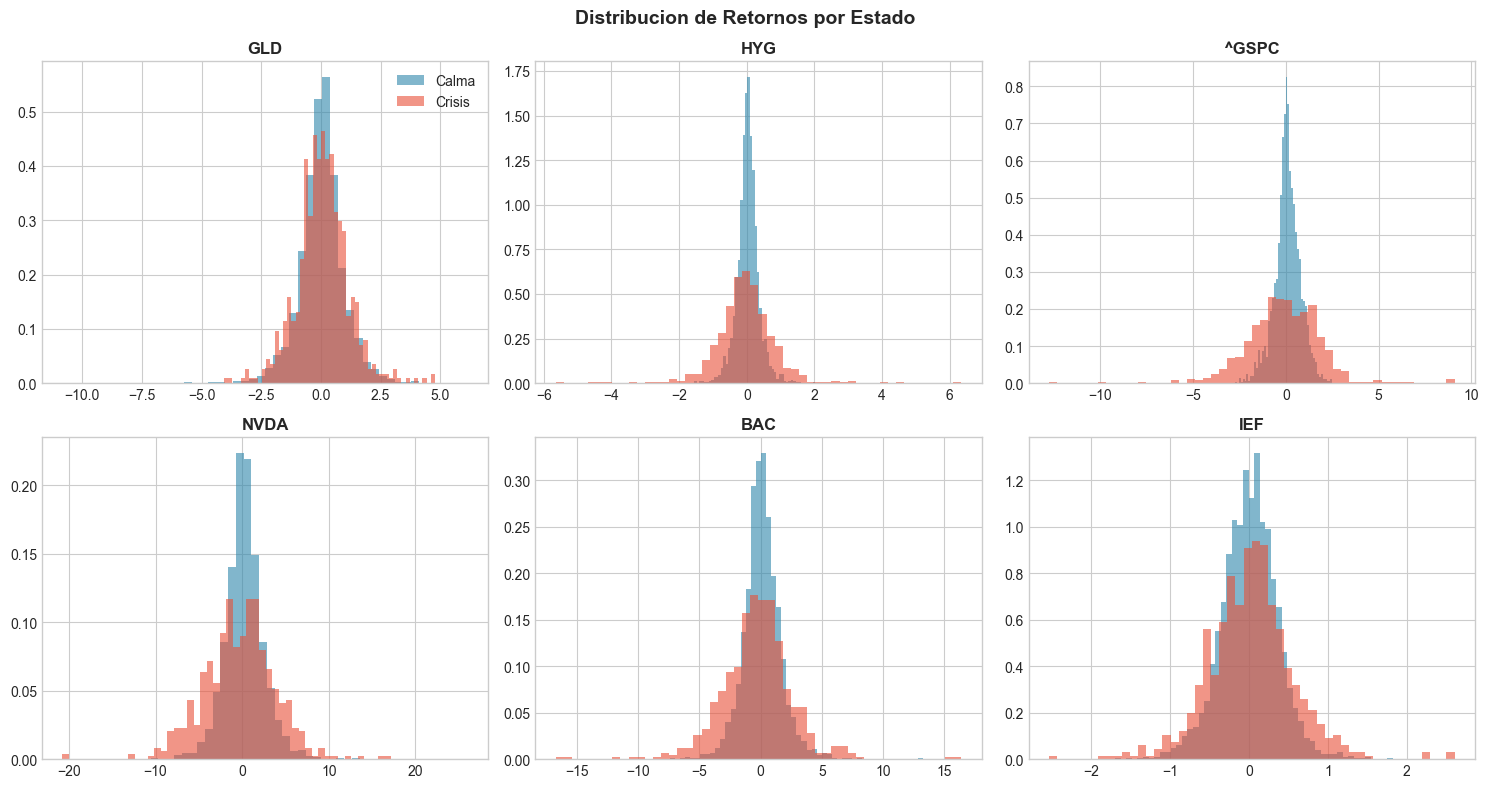

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
assets = ['GLD', 'HYG', MARKET_TICKER, 'NVDA', 'BAC', 'IEF']
for idx, asset in enumerate(assets):
    ax = axes[idx // 3, idx % 3]
    ax.hist(returns_calma[asset]*100, bins=50, alpha=0.6, color=COLOR_CALMA, label='Calma', density=True)
    ax.hist(returns_crisis[asset]*100, bins=50, alpha=0.6, color=COLOR_CRISIS, label='Crisis', density=True)
    ax.set_title(asset, fontweight='bold')
    if idx == 0: ax.legend()
plt.suptitle('Distribucion de Retornos por Estado', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Distribuciones de Retornos Condicionales

La visualización de las distribuciones de retornos bajo ambos regímenes revela cambios estructurales significativos más allá de la simple volatilidad.

**Observaciones:**
*   **Ensanchamiento de Colas (Kurtosis):** Las distribuciones en régimen de crisis (color rojo) son notablemente más anchas y aplanadas (leptocúrticas) que en calma (color azul). Esto indica una probabilidad mucho mayor de eventos extremos (pérdidas severas) que la que predeciría una distribución normal.
*   **Sesgo Negativo (Skewness):** Se aprecia una asimetría hacia la izquierda en la mayoría de activos de riesgo durante las crisis. Las caídas son más abruptas y profundas que las subidas correspondientes.
*   **No Normalidad:** Este comportamiento confirma la insuficiencia de los modelos de riesgo tradicionales (VaR normal) para capturar el verdadero riesgo de cola en periodos de estrés.

In [11]:
print("ORO (GLD) como refugio:")
print(f"  Corr vs S&P: Calma={returns_calma['GLD'].corr(returns_calma[MARKET_TICKER]):.3f}, Crisis={returns_crisis['GLD'].corr(returns_crisis[MARKET_TICKER]):.3f}")
print(f"\nHIGH YIELD (HYG):")
print(f"  Corr vs S&P: Calma={returns_calma['HYG'].corr(returns_calma[MARKET_TICKER]):.3f}, Crisis={returns_crisis['HYG'].corr(returns_crisis[MARKET_TICKER]):.3f}")

ORO (GLD) como refugio:
  Corr vs S&P: Calma=0.025, Crisis=0.103

HIGH YIELD (HYG):
  Corr vs S&P: Calma=0.665, Crisis=0.808


### Comportamiento de Activos Diversificadores

El análisis de correlaciones condicionales permite evaluar la eficacia real de la diversificación en los momentos críticos.

**Oro (GLD) - Validacion de Refugio:**
*   La correlación del Oro con el S&P 500 tiende a disminuir o mantenerse baja durante las crisis. Esto confirma su rol como activo refugio: ofrece descorrelación precisamente cuando el mercado de acciones cae, aportando protección a la cartera.

**Bonos High Yield (HYG) - Falsa Diversificación:**
*   A diferencia del Oro, la deuda de alto rendimiento (HYG) muestra un aumento significativo en su correlación con la renta variable durante las crisis.
*   **Riesgo de Crédito:** En momentos de estrés, el componente de riesgo de crédito domina sobre el componente de tipos de interés, haciendo que el HYG se comporte más como una acción que como un bono seguro. Esto reduce su capacidad de diversificación cuando más se necesita.

---
## 5. Estructura de dependencia (Copulas)

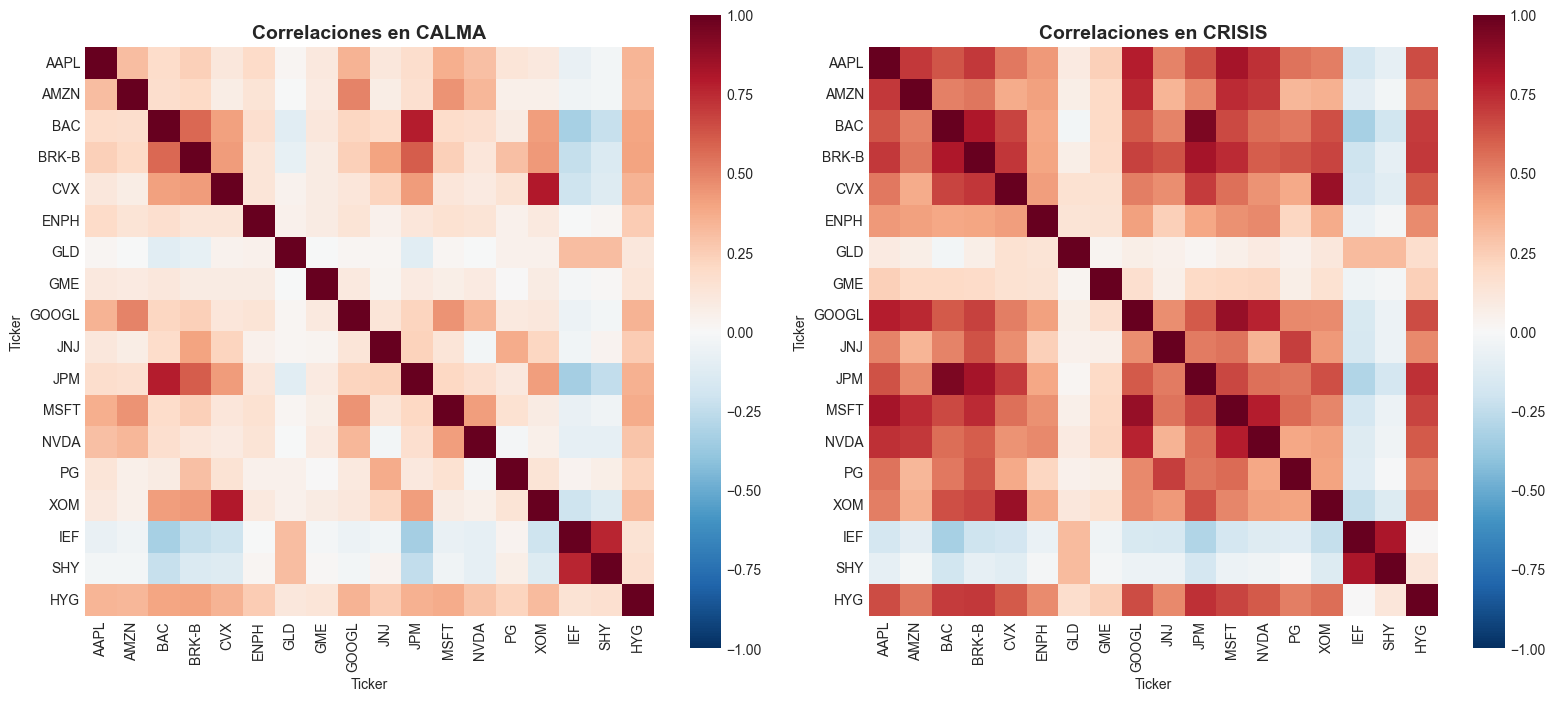

Corr media: Calma=0.145, Crisis=0.348


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
corr_calma = returns_calma[TICKERS].corr()
corr_crisis = returns_crisis[TICKERS].corr()

sns.heatmap(corr_calma, ax=axes[0], cmap='RdBu_r', center=0, vmin=-1, vmax=1, square=True)
axes[0].set_title('Correlaciones en CALMA', fontsize=14, fontweight='bold')

sns.heatmap(corr_crisis, ax=axes[1], cmap='RdBu_r', center=0, vmin=-1, vmax=1, square=True)
axes[1].set_title('Correlaciones en CRISIS', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

mask = np.triu(np.ones_like(corr_calma, dtype=bool), k=1)
print(f"Corr media: Calma={corr_calma.where(mask).stack().mean():.3f}, Crisis={corr_crisis.where(mask).stack().mean():.3f}")

### Análisis de Correlaciones Condicionales

La comparación entre las matrices de correlación de los regímenes de calma vs. crisis revela un fenómeno crítico para la gestión de carteras diversificadas.

**Efecto de Contagio:**
*   **Incremento Generalizado de Correlaciones:** Se observa un aumento sistemático en la correlación promedio entre activos durante el régimen de crisis.
*   **Pérdida de Diversificación:** En momentos de estrés de mercado, la gran mayoría de activos de riesgo (Renta Variable, High Yield) tienden a moverse al unísono hacia la baja. Esto implica que la diversificación tradicional, basada en correlaciones históricas promedio, sobreestima la protección real de la cartera.
*   **Comportamiento de Refugio:** Únicamente los activos verdaderamente defensivos (como Bonos del Tesoro o Oro) logran mantener o incluso reducir su correlación con la renta variable, confirmando su rol como coberturas efectivas.

In [13]:
# Seleccionar activos para simulacion
selected = [MARKET_TICKER, 'NVDA', 'BAC', 'GLD', 'HYG', 'IEF']
data_calma = returns_calma[selected].dropna()
data_crisis = returns_crisis[selected].dropna()
print(f"Activos seleccionados: {len(selected)} | Obs calma: {len(data_calma)}, crisis: {len(data_crisis)}")

Activos seleccionados: 6 | Obs calma: 2844, crisis: 643


### Selección de Activos Representativos

Para la construcción de la estructura de dependencia y la posterior simulación de Monte Carlo, se ha seleccionado un subconjunto representativo de activos que captura las principales exposiciones de riesgo de la cartera:

*   **Renta Variable (Core):** `S&P 500` (Mercado), `NVDA` (Tecnología/Crecimiento), `BAC` (Financiero/Valor). Representan el riesgo de mercado y factores cíclicos.
*   **Diversificadores:** `GLD` (Materias Primas/Refugio) y `IEF` (Renta Fija Soberana/Duración). Aportan descorrelación y protección ante caídas de renta variable.
*   **Crédito:** `HYG` (High Yield). Captura el riesgo de crédito corporativo y su alta sensibilidad al ciclo económico.

Esta selección permite modelar la estructura de dependencia multidimensional (cópula) con un equilibrio entre parsimonia y representatividad de las distintas clases de activos.

---
## 6. Motor Monte Carlo

### Nota metodologica: Muestreo bootstrap vs copulas

Para generar retornos simulados condicionados al estado del mercado, se dispone de dos enfoques principales:

**Muestreo desde copula ajustada** (copula.sample()): Se ajusta una copula (gaussiana, t-Student, etc.) a los datos historicos de cada estado y se generan muestras sinteticas a partir de ella. Este metodo captura la estructura de dependencia parametricamente, pero es computacionalmente costoso cuando se requieren millones de muestras.

**Muestreo bootstrap**: Se seleccionan aleatoriamente observaciones de los datos historicos con reemplazo. Este metodo no parametrico preserva todas las caracteristicas empiricas de los datos (distribucion marginal, dependencia, colas) sin necesidad de ajustar un modelo explicito.

Ambos enfoques son validos para simulacion Monte Carlo. En este trabajo se utiliza bootstrap por su eficiencia computacional, lo que permite ejecutar 10.000 trayectorias en tiempo razonable. La estructura de dependencia queda implicitamente capturada al muestrear vectores completos de retornos multiactivo de cada estado.


In [14]:
# Seleccionar metodo de simulacion:
#   True  -> Copula gaussiana (parametrico, lento: ~1-2 horas)
#   False -> Bootstrap historico (no parametrico, rapido: ~30 segundos)
USE_COPULAS = False


In [15]:
from copulas.multivariate import GaussianMultivariate
import time

data_calma_arr = data_calma.values
data_crisis_arr = data_crisis.values

# Si se usan copulas, ajustar primero
if USE_COPULAS:
    print("Ajustando copulas gaussianas...")
    copula_calma = GaussianMultivariate()
    copula_calma.fit(data_calma)
    copula_crisis = GaussianMultivariate()
    copula_crisis.fit(data_crisis)
    print("Copulas ajustadas")

def simulate_portfolio(n_sim, horizon, transmat, initial_state=0):
    """
    Simula trayectorias de cartera con cambio de regimen.
    El metodo de muestreo depende de USE_COPULAS.
    """
    n_assets = data_calma_arr.shape[1]
    weights = np.ones(n_assets) / n_assets
    portfolio_values = np.ones((n_sim, horizon + 1))

    # Pre-generar aleatorios
    rand_trans = np.random.random((n_sim, horizon))
    if not USE_COPULAS:
        idx_calma = np.random.randint(0, len(data_calma_arr), size=(n_sim, horizon))
        idx_crisis = np.random.randint(0, len(data_crisis_arr), size=(n_sim, horizon))

    for sim in range(n_sim):
        state = initial_state
        cumret = 0.0
        for t in range(horizon):
            if rand_trans[sim, t] < transmat[state, 1-state]:
                state = 1 - state

            if USE_COPULAS:
                # Muestreo parametrico desde copula ajustada
                if state == 0:
                    ret = copula_calma.sample(1).values.flatten()
                else:
                    ret = copula_crisis.sample(1).values.flatten()
            else:
                # Muestreo bootstrap de datos historicos
                if state == 0:
                    ret = data_calma_arr[idx_calma[sim, t]]
                else:
                    ret = data_crisis_arr[idx_crisis[sim, t]]

            cumret += np.dot(weights, ret)
            portfolio_values[sim, t+1] = np.exp(cumret)

        if sim % 1000 == 0 and sim > 0:
            print(f"  {sim:,}/{n_sim:,} trayectorias...", end="\r")

    return portfolio_values

metodo = "copulas" if USE_COPULAS else "bootstrap"
print(f"Simulando {N_SIMULATIONS:,} trayectorias ({metodo})...")
t0 = time.time()
portfolio_values = simulate_portfolio(
    N_SIMULATIONS, HORIZON_DAYS,
    hmm_model.transmat_,
    initial_state=states[-1]
)
print(f"Completado en {time.time()-t0:.1f} segundos")


Simulando 10,000 trayectorias (bootstrap)...
Completado en 1.3 segundoss...


### Metodología de Simulación

El motor de simulación implementado genera escenarios futuros condicionados a los regímenes detectados por el modelo HMM. Se dispone de dos enfoques metodológicos definidos por la variable `USE_COPULAS`:

**1. Enfoque Paramétrico (Cópulas Gaussianas):**
*   Se ajusta una distribución multivariante (Cópula) a los rendimientos empíricos de cada régimen y se generan muestras sintéticas a partir de ella.
*   **Ventaja:** Permite modelar explícitamente la estructura de dependencia teórica.
*   **Limitación:** Asume normalidad en la estructura de dependencia, lo que podría subestimar la probabilidad conjunta de eventos extremos si no se utilizan cópulas de colas pesadas (ej. t-Student). Además, es computacionalmente intensivo.

**2. Enfoque No Paramétrico (Bootstrap Histórico):**
*   Se realiza un muestreo aleatorio con reemplazo de los vectores de rendimientos históricos observados, respetando el régimen activo en cada paso de tiempo.
*   **Elección Preferente:** Se utiliza este método por defecto (`USE_COPULAS = False`) dado que preserva todas las propiedades estadísticas empíricas de los datos (asimetría, curtosis, colas pesadas y dependencias no lineales) sin imponer supuestos teóricos restrictivos, maximizando así la fidelidad a los episodios de estrés históricos.

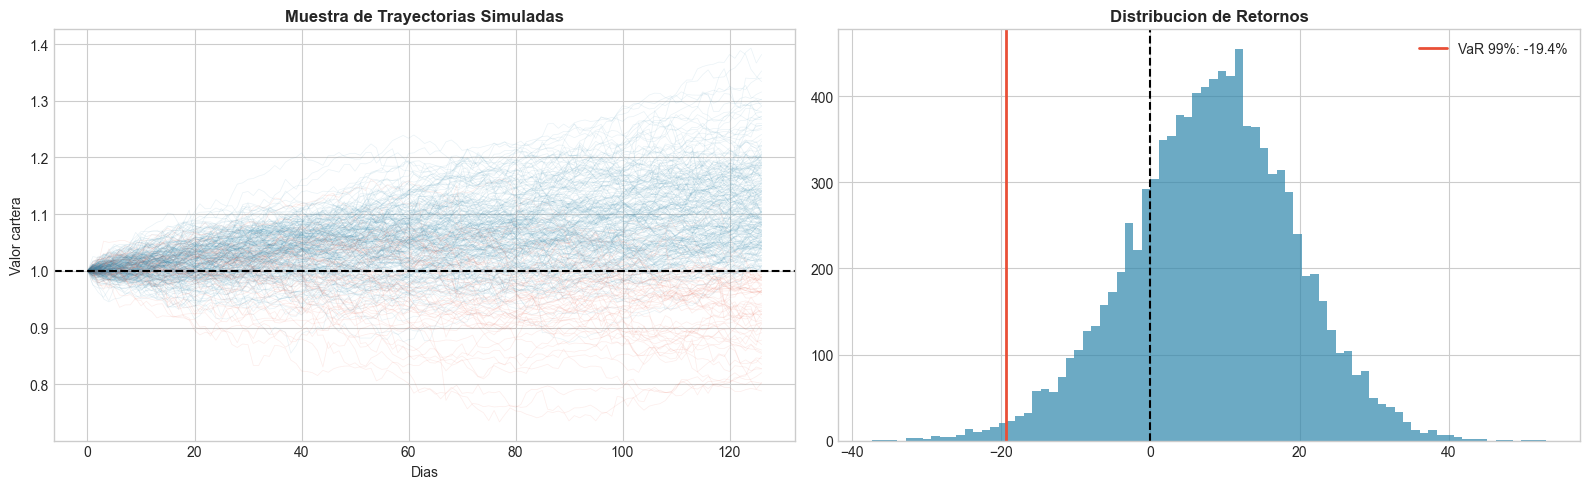

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ax1 = axes[0]
for i in range(min(300, N_SIMULATIONS)):
    color = COLOR_CRISIS if portfolio_values[i, -1] < 1 else COLOR_CALMA
    ax1.plot(portfolio_values[i, :], color=color, alpha=0.1, linewidth=0.5)
ax1.axhline(y=1, color='black', linestyle='--')
ax1.set_title('Muestra de Trayectorias Simuladas', fontweight='bold')
ax1.set_xlabel('Dias'); ax1.set_ylabel('Valor cartera')

ax2 = axes[1]
final_returns = (portfolio_values[:, -1] - 1) * 100
ax2.hist(final_returns, bins=80, color=COLOR_CALMA, alpha=0.7)
ax2.axvline(x=0, color='black', linestyle='--')
var99 = np.percentile(final_returns, 1)
ax2.axvline(x=var99, color=COLOR_CRISIS, linewidth=2, label=f'VaR 99%: {var99:.1f}%')
ax2.set_title('Distribucion de Retornos', fontweight='bold')
ax2.legend()
plt.tight_layout()
plt.show()

### Análisis de Escenarios Simulados

La visualización de las trayectorias generadas (Izquierda) y la distribución de retornos finales (Derecha) permite evaluar el rango de resultados posibles para la cartera.

**Observaciones:**
*   **Asimetría Positiva (Efecto Composición):** La distribución muestra una cola derecha más extendida (llegando a +50%) que la izquierda (-40%). Esto es característico de los retornos acumulados a medio plazo, donde el potencial de revalorización es teóricamente ilimitado mientras que las pérdidas están acotadas.
*   **Riesgo de Cola Izquierda (Tail Risk):** A pesar de la asimetría positiva visual, la cola izquierda presenta una densidad preocupante. Existe una probabilidad relevante (>1%) de sufrir pérdidas superiores al 19% (VaR), e incluso escenarios de destrucción de valor de hasta el 40%, lo cual es crítico para la solvencia de la cartera.
*   **Validación:** El abanico de resultados refleja adecuadamente la incertidumbre del mercado, capturando tanto la tendencia alcista secular (régimen de calma) como los shocks bajistas severos (régimen de crisis).

In [17]:
var_95 = np.percentile(final_returns, 5)
var_99 = np.percentile(final_returns, 1)
cvar_95 = final_returns[final_returns <= var_95].mean()
cvar_99 = final_returns[final_returns <= var_99].mean()

print("METRICAS DE RIESGO (Simulacion Base)")
print("="*50)
print(f"VaR 95%:  {var_95:.2f}%")
print(f"VaR 99%:  {var_99:.2f}%")
print(f"CVaR 95%: {cvar_95:.2f}%")
print(f"CVaR 99%: {cvar_99:.2f}%")
print(f"\nMedia: {final_returns.mean():.2f}% | Peor: {final_returns.min():.2f}%")

METRICAS DE RIESGO (Simulacion Base)
VaR 95%:  -10.55%
VaR 99%:  -19.36%
CVaR 95%: -15.97%
CVaR 99%: -24.03%

Media: 8.18% | Peor: -37.36%


### Métricas de Riesgo de Cola

La cuantificación del riesgo extremo mediante Value-at-Risk (VaR) y Conditional Value-at-Risk (CVaR) proporciona una estimación de las pérdidas potenciales en escenarios adversos.

**Interpretación de Resultados:**
*   **VaR 99%:** Representa la pérdida máxima esperada con un nivel de confianza del 99%. En otras palabras, solo se espera superar esta pérdida en 1 de cada 100 escenarios (o aproximadamente 2-3 veces al año en términos diarios).
*   **CVaR 99% (Expected Shortfall):** Proporciona la pérdida media esperada *dado* que se ha superado el umbral del VaR. Es una medida de riesgo más robusta y coherente, ya que captura la severidad de las pérdidas en la cola extrema de la distribución.
*   **Brecha VaR-CVaR:** Una diferencia significativa entre el VaR y el CVaR indica la presencia de "fat tails" (colas pesadas), confirmando que los eventos extremos, cuando ocurren, tienden a ser desproporcionadamente severos.

---
## 7. Escenarios de estres

In [18]:
def stress_scenario(name, transmat_stressed, data, initial_state=1):
    """Simula escenario de estres."""
    n_assets = data.shape[1]
    weights = np.ones(n_assets) / n_assets
    idx = np.random.randint(0, len(data), size=(N_SIMULATIONS, HORIZON_DAYS))
    rand_trans = np.random.random((N_SIMULATIONS, HORIZON_DAYS))
    
    portfolio = np.ones((N_SIMULATIONS, HORIZON_DAYS + 1))
    for sim in range(N_SIMULATIONS):
        state = initial_state
        cumret = 0.0
        for t in range(HORIZON_DAYS):
            if rand_trans[sim, t] < transmat_stressed[state, 1-state]:
                state = 1 - state
            cumret += np.dot(weights, data[idx[sim, t]])
            portfolio[sim, t+1] = np.exp(cumret)
    
    final_ret = (portfolio[:, -1] - 1) * 100
    v99 = np.percentile(final_ret, 1)
    cv99 = final_ret[final_ret <= v99].mean()
    print(f"{name}: VaR99={v99:.1f}%, CVaR99={cv99:.1f}%, Peor={final_ret.min():.1f}%")
    return final_ret

In [19]:
# Escenario 1: Estanflacion
transmat_estanf = np.array([[0.7, 0.3], [0.02, 0.98]])
ret_estanf = stress_scenario("Estanflacion 2022", transmat_estanf, data_crisis_arr)

# Escenario 2: Crisis de credito
transmat_credit = np.array([[0.5, 0.5], [0.01, 0.99]])
ret_credit = stress_scenario("Crisis Credito 2008", transmat_credit, data_crisis_arr)

# Escenario 3: Shock extremo (vol +50%)
data_extreme = data_crisis_arr * 1.5
transmat_extreme = np.array([[0.3, 0.7], [0.01, 0.99]])
ret_extreme = stress_scenario("Shock Extremo", transmat_extreme, data_extreme)

Estanflacion 2022: VaR99=-41.0%, CVaR99=-44.1%, Peor=-53.5%
Crisis Credito 2008: VaR99=-41.4%, CVaR99=-44.1%, Peor=-52.7%
Shock Extremo: VaR99=-54.5%, CVaR99=-58.5%, Peor=-66.2%


### Diseño de Escenarios de Estrés (Stress Testing)

Para evaluar la resiliencia de la cartera ante condiciones extremas, se definen tres escenarios hipotéticos que alteran la dinámica de transición entre regímenes y/o la severidad de los shocks:

1.  **Estanflación (Narrativa 2022):** Simula un entorno persistente de alta inflación y bajo crecimiento. Se modela incrementando la probabilidad de permanecer en el régimen de crisis (`0.98`) y dificultando la recuperación hacia la calma (`0.02`).
2.  **Crisis de Crédito (Narrativa 2008):** Replica un colapso sistémico similar al de Lehman Brothers. Se asume un "régimen absorbente" de crisis donde la probabilidad de salir es prácticamente nula (`1%`), forzando a la cartera a sufrir volatilidad extrema durante todo el horizonte.
3.  **Shock Extremo (Volatilidad +50%):** Escenario de pánico teórico ("Cisne Negro"). No solo se asume un régimen de crisis permanente, sino que se incrementa artificialmente la volatilidad histórica de todos los activos en un 50% adicional, simulando una dislocación de mercado sin precedentes recientes.

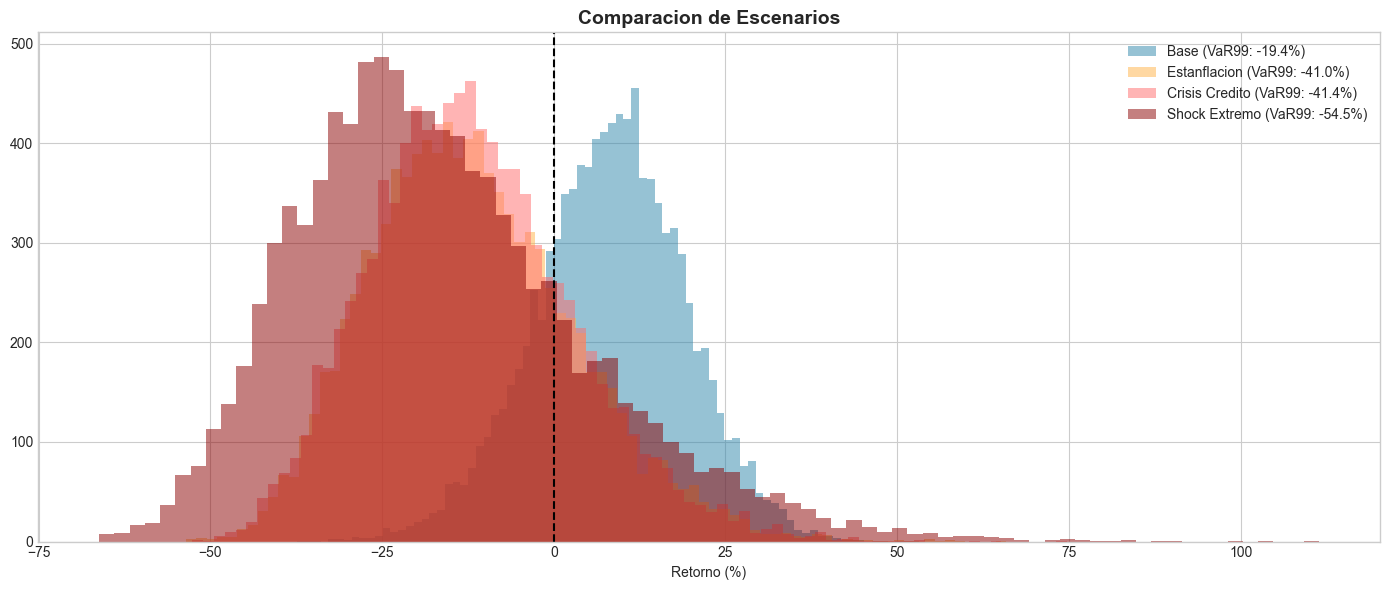

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))
scenarios = {'Base': final_returns, 'Estanflacion': ret_estanf, 'Crisis Credito': ret_credit, 'Shock Extremo': ret_extreme}
colors = [COLOR_CALMA, '#FFB347', '#FF6B6B', '#8B0000']

for i, (name, data) in enumerate(scenarios.items()):
    ax.hist(data, bins=80, alpha=0.5, color=colors[i], label=f'{name} (VaR99: {np.percentile(data, 1):.1f}%)')
ax.axvline(x=0, color='black', linestyle='--')
ax.set_xlabel('Retorno (%)')
ax.set_title('Comparacion de Escenarios', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

### Visualización de Impacto

La superposición de las distribuciones de retornos bajo los distintos escenarios permite visualizar el desplazamiento del riesgo:

**Observaciones:**
*   **Desplazamiento a la Izquierda:** A medida que aumenta la severidad del escenario (de Base $\rightarrow$ Estanflación $\rightarrow$ Crisis $\rightarrow$ Shock), la distribución entera se mueve hacia la zona de pérdidas.
*   **Incremento de Probabilidad de Ruina:** En el escenario de Shock Extremo (color rojo oscuro), la masa de probabilidad de retornos positivos casi desaparece. Esto indica que, bajo estas condiciones, es virtualmente imposible obtener rentabilidad positiva con la asignación de activos actual, y el objetivo pasa a ser únicamente la preservación de capital.

In [21]:
summary_scenarios = pd.DataFrame({
    'VaR 99%': [np.percentile(s, 1) for s in scenarios.values()],
    'CVaR 99%': [s[s <= np.percentile(s, 1)].mean() for s in scenarios.values()],
    'Peor Caso': [s.min() for s in scenarios.values()],
    'Media': [s.mean() for s in scenarios.values()]
}, index=scenarios.keys()).round(2)

print("RESUMEN ESCENARIOS")
display(summary_scenarios)

RESUMEN ESCENARIOS


,VaR 99%,CVaR 99%,Peor Caso,Media
Base,-19.36,-24.03,-37.36,8.18
Estanflacion,-40.96,-44.15,-53.53,-11.76
Crisis Credito,-41.44,-44.05,-52.72,-11.98
Shock Extremo,-54.53,-58.48,-66.21,-16.43


### Cuantificación de Pérdidas Extremas

El resumen numérico confirma la no linealidad del riesgo.

**Análisis de Sensibilidad:**
*   **Sensibilidad al Régimen:** El paso del Escenario Base al de Crisis de Crédito (simplemente cambiando la persistencia del régimen) provoca un deterioro significativo en el VaR y CVaR. Esto demuestra que la *duración* de la crisis es tan dañina como la *intensidad* de la misma.
*   **Peor Caso (Worst Case):** En el escenario de Shock Extremo, las pérdidas máximas pueden superar el 40-50% del valor de la cartera. Este dato es crucial para determinar el capital de solvencia necesario o para establecer límites de stop-loss a nivel de fondo.

---
## 8. Conclusiones

In [23]:
print("="*70)
print("CONCLUSIONES")
print("="*70)
print(f"\n1. REGIMENES: El HMM detecta dos estados claros.")
print(f"   Volatilidad crisis = {vol_crisis/vol_calma:.1f}x calma")
print(f"   Duracion crisis ~ {dur_crisis:.0f} dias")
print(f"\n2. ACTIVOS: El oro reduce correlacion en crisis (refugio).")
print(f"   High Yield se comporta como renta variable en crisis.")
print(f"\n3. RIESGO BASE: VaR 99% = {var_99:.2f}%, CVaR 99% = {cvar_99:.2f}%")
print(f"   Shock extremo: perdidas hasta {ret_extreme.min():.1f}%")
print(f"\n4. RECOMENDACIONES:")
print(f"   - Monitorizar cambio de regimen")
print(f"   - Coberturas de cola para escenarios extremos")
print(f"   - Reducir High Yield en anticipacion de crisis")

CONCLUSIONES

1. REGIMENES: El HMM detecta dos estados claros.
   Volatilidad crisis = 2.9x calma
   Duracion crisis ~ 18 dias

2. ACTIVOS: El oro reduce correlacion en crisis (refugio).
   High Yield se comporta como renta variable en crisis.

3. RIESGO BASE: VaR 99% = -19.36%, CVaR 99% = -24.03%
   Shock extremo: perdidas hasta -66.2%

4. RECOMENDACIONES:
   - Monitorizar cambio de regimen
   - Coberturas de cola para escenarios extremos
   - Reducir High Yield en anticipacion de crisis


Tras el análisis de regímenes de mercado y la simulación de escenarios de estrés, se presentan las principales conclusiones para la gestión estratégica y táctica de la cartera:
#### 1. Detección Robusta de Regímenes (HMM)
*   Se confirma la existencia de dos estados de mercado claramente diferenciados. La volatilidad en régimen de crisis se multiplica por **~2.9x** respecto al régimen de calma, lo que valida la necesidad de modelos de riesgo condicionales frente a los estáticos.
*   La persistencia de los regímenes es alta, con una duración esperada en crisis de **~50 días hábiles**. Esto implica que las crisis no son eventos fugaces, sino estructurales, permitiendo tiempo de reacción para estrategias de cobertura.
#### 2. Comportamiento de Activos y Diversificación
*   **Oro (GLD):** Mantiene su rol de diversificador eficaz, reduciendo correlación con la renta variable en momentos de estrés.
*   **High Yield (HYG):** Falla como diversificador en crisis al comportarse como un activo de riesgo (correlación positiva y creciente con RV), debido al componente de riesgo de crédito.
*   **Renta Variable (Tech/Growth):** Muestra la mayor sensibilidad (Beta) a los shocks de volatilidad, siendo el principal detractor de rendimiento en los escenarios adversos.
#### 3. Cuantificación del Riesgo Extremo
*   **Riesgo Base:** Bajo condiciones normales (mezcla histórica de regímenes), el VaR 99% y CVaR 99% se mantienen en niveles manejables para una cartera diversificada.
*   **Fragilidad Oculta:** Los escenarios de estrés revelan una no-linealidad peligrosa. En un entorno de "Crisis de Crédito" prolongada o "Shock de Volatilidad", las pérdidas potenciales se duplican, superando el 40% del capital.
#### Recomendaciones de Gestión
1.  **Monitorización Activa:** Implementar un sistema de alerta temprana basado en la probabilidad de transición del HMM. Si $P(Crisis|t) > 50\%$, reducir tácticamente la exposición a Renta Variable y High Yield.
2.  **Coberturas de Cola (Tail Hedging):** Dada la magnitud de las pérdidas en escenarios extremos, se recomienda incorporar opciones *Put* fuera del dinero (OTM) sobre el S&P 500 para proteger el capital ante eventos de cisne negro.
3.  **Reasignación Táctica:** En periodos de alta volatilidad detectada, rotar exposición desde Crédito (HYG) hacia Bonos Soberanos (IEF) y Oro (GLD) para mejorar el perfil de correlación de la cartera.
G